Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**

In [188]:
!pip install -Uq wandb



# TP3: Clasificador de imagenes


``torchvision`` contiene  data loaders para datasets conocidos como ImageNet, CIFAR10, MNIST, etc.
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

El dataset CIFAR10 contiene las siguientes clases: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Las imagenes son de tamaño 3x32x32, i.e. imagenes de color de 3 canales (RGB) de 32x32 pixels en tamaño.


## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Cargamos los datos CIFAR10 y preparamos los sets de training, validation y test.
2. Definimos las redes. Una MLP, un una CNN
3. Definimos la loss
4. Entrenamos
5. Evaluamos en Test

### 1.Carga de datos CIFAR10


In [2]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 1.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip install scikit-learn wandb


In [1]:
import torch

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='mps', index=0)

In [2]:
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.utils.data
import numpy as np


In [3]:
import wandb

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ignacio-pardo (pardo). Use `wandb login --relogin` to force relogin


True

In [4]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [6]:
batch_size = 32


In [7]:
import os

#check if data is already downloaded
download = not os.path.isdir('./data')


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
targets_ = trainset.targets
train_idx, val_idx = train_test_split(
    np.arange(len(targets_)), test_size=0.2, stratify=targets_
)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(
    trainset, sampler=train_sampler, batch_size=batch_size, num_workers=2
)
valloader = torch.utils.data.DataLoader(
    trainset, sampler=val_sampler, batch_size=batch_size, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


Let us show some of the training images, for fun.



In [13]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


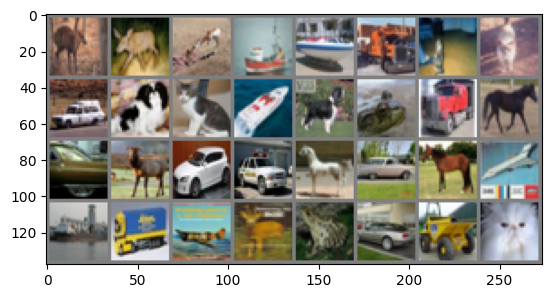

deer  deer  deer  ship  ship  truck cat   cat   car   dog   cat   ship  dog   frog  truck horse car   deer  car   car   horse car   horse plane ship  truck plane deer  frog  car   truck cat  


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### 2. Definimos las redes



In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 32 * 32 * 3)
        self.fc21 = nn.Linear(32 * 32 * 3, 32 * 32)
        self.d1 = nn.Dropout(0.2)
        self.fc22 = nn.Linear(32 * 32, 800)
        self.d2 = nn.Dropout(0.2)
        self.fc23 = nn.Linear(800, 360)
        self.fc24 = nn.Linear(360, 480)
        self.fc25 = nn.Linear(480, 240)
        self.fc26 = nn.Linear(240, 120)
        self.d3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 24)
        self.fc4 = nn.Linear(24, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc22(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc24(x))
        x = F.leaky_relu(self.fc25(x))
        x = F.leaky_relu(self.fc26(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

experiment_name = "MPS Larger3 Softmax Dropout LeakyRelu"
net = Net()
net.to(device)


Net(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc21): Linear(in_features=3072, out_features=1024, bias=True)
  (d1): Dropout(p=0.2, inplace=False)
  (fc22): Linear(in_features=1024, out_features=800, bias=True)
  (d2): Dropout(p=0.2, inplace=False)
  (fc23): Linear(in_features=800, out_features=360, bias=True)
  (fc24): Linear(in_features=360, out_features=480, bias=True)
  (fc25): Linear(in_features=480, out_features=240, bias=True)
  (fc26): Linear(in_features=240, out_features=120, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=10, bias=True)
)

In [ ]:


class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc21 = nn.Linear(120, 120)
        self.fc22 = nn.Linear(120, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = F.relu(self.fc22(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 3. Definimos la loss y el optimizador




In [25]:
#Parametros
learning_rate = 0.02
momentum = .9
epochs = 20
project_name = "TP3"


In [13]:
import torch.optim as optim


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)


### 4. Entrenamos

Deberiamos plotear la loss para el validation set tb!



In [27]:
wandb.init(
    # set the wandb project where this run will be logged
    project=project_name,
    name=experiment_name,
    # track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    },
)


In [19]:
%pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 238.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
from tqdm import tqdm


In [28]:
iterator = tqdm(range(epochs), total=epochs, desc="Epoch")
for epoch in iterator:  # loop over the dataset multiple times

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 200 == 199:  # print every 200 mini-batches
        #    print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # End of test section
    # Val section
    train_accuracy = 100 * train_correct / total
    running_loss = running_loss / total

    val_correct = 0
    total = 0
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    # End of test section

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    wandb.log(
        {
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": running_loss,
            "val_loss": val_loss,
        }
    )

    iterator.set_postfix(
        {
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": running_loss,
            "val_loss": val_loss,
        }
    )

print("Finished Training")

wandb.finish()


Epoch: 100%|██████████| 20/20 [2:01:31<00:00, 364.55s/it, train_accuracy=71, val_accuracy=52, train_loss=0.0267, val_loss=0.052]        

Finished Training


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇▇▇█▇█████████
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▂▁▂▂▂▂
train_accuracy,71.015
train_loss,0.02671
val_accuracy,51.95
val_loss,0.05199


In [18]:
wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,█▁
train_loss,█▁
val_accuracy,█▁
val_loss,▁▁
train_accuracy,10.1225
train_loss,0.07196
val_accuracy,10.0
val_loss,0.07207


Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.



In [198]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)




### 5. Una vez elegido todos los hyper-parametros, evaluar el mejor modelo en Test




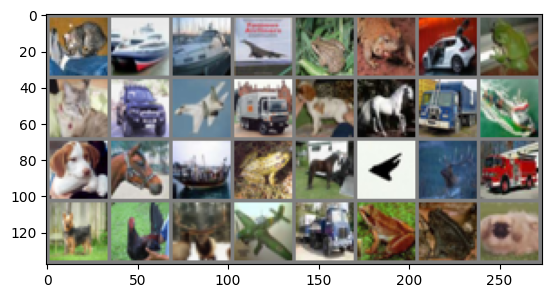

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [199]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))


Cargamos el modelo (el mejor) y evaluamos en un ejemplo


In [200]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  cat   ship  ship  ship 



Evaluamos en el set de test



In [201]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")


Accuracy of the network on the 10000 test images: 50 %


Algo estamos aprendiendo! Si fuese random, seria 10% accuracy (elegir random entre 10 clases).
Algunas clases se comportan peor que otras.


In [202]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")


Accuracy for class: plane is 50.1 %
Accuracy for class: car   is 54.8 %
Accuracy for class: bird  is 31.3 %
Accuracy for class: cat   is 34.8 %
Accuracy for class: deer  is 58.6 %
Accuracy for class: dog   is 43.0 %
Accuracy for class: frog  is 51.9 %
Accuracy for class: horse is 53.9 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 54.7 %
